In [10]:
import os
import h5py
from pandas.core.frame import DataFrame
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import Dataset

# from CMAPSS.utils.transformations import MinMaxScaler

In [11]:
class CMAPSS(Dataset):
    """

    Attributes:
        kind: {'TSF', 'RUL'}
        split: {'train', 'test', 'test_plus'}
     
    """ 

    def __init__(
            self,
            dataset_name='FD001',
            dir_path='/Users/yuhanlin/Documents/Dokument/Uni-Hannover/Masterarbeit/dataset/17#Turbofan Engine Degradation Simulation Data Set2/data_set',
            steps_before=None,
            steps_after=None,
            transformations=[],
            kind='TSF',
            data_split='train',
            random_seed=42,
            val_size=0.2,
            rul_args={'return_last_rul': True, 'max_rul': 125},
            return_idx=False,
            drop_sensors=None,
    ):
    
        super().__init__()

        self.dataset_name = dataset_name
        self.dir_path = dir_path
        self.data_split = data_split
        self.kind = kind

        self.random_seed = random_seed
        self.val_size = val_size

        self.index_names = ['unit_idx', 'time_cycles']
        self.setting_names = ['setting_1', 'setting_2', 'setting_3']
        self.sensor_names = ['s_{}'.format(i) for i in range(1,22)]
        
        self.steps_before = steps_before
        self.steps_after = steps_after
        self.transformations = transformations

        self.rul_args = rul_args

        if drop_sensors is None:
            self.drop_sensors = self.get_drop_sensors()
        else:
            self.drop_sensors = drop_sensors

        self.df = self.load_data()

        self.num_features = 21 - len(self.drop_sensors)

        if self.steps_before is not None and self.steps_after is not None: 
            self.index_map = self._getindexmap()

        self.return_idx = return_idx

        self.check_parsed_args()

    def check_parsed_args(self):
        if self.kind == 'RUL':
            assert self.steps_after == 0, 'steps_after has to be set to 0'
            # assert self.steps_before is not None
        
    def __len__(self):

        if self.steps_before is None or (self.kind == 'RUL' and self.data_split == 'test'):
            return self.get_num_units()
        else:
            return len(self.index_map)

    def _getindexmap(self):
        index_map = dict()
        # num_units = self.get_num_units()
        
        # assert np.isin(self.df['unit_idx'].unique(), range(num_units)).all()

        unit_ids = self.df['unit_idx'].unique()
        
        idx_count = 0
        for unit_idx in unit_ids:
            unit_seq = self.df[self.df['unit_idx'] == unit_idx]
            max_offset = len(unit_seq) - self.steps_before - self.steps_after
            for offset in range(max_offset+1):
                curr_timeidx = offset + self.steps_before - 1
                index_map[idx_count] = [unit_idx, curr_timeidx]
                idx_count += 1
        return index_map

    def get_num_units(self):
        return len(self.df.groupby(by="unit_idx"))

    def __getitem__(self, index):

        if index >= len(self): raise IndexError

        if self.kind == 'TFS':
            return self._getitem_TSF(index)
        elif self.kind == 'RUL':
            return self._getitem_RUL(index, **self.rul_args)
        else:
            raise ValueError('Not supported kind')

    def _getitem_TSF(self, index):
        if self.steps_before is None and self.steps_after is None:
            # get the whole seq of the unit 
            seq_df = self._get_unit_seq(index)
        else:          
            # get cropped sequence
            seq_df = self._get_crop_seq(index)

        drop_columns = self.index_names + self.setting_names
        seq_df.drop(labels=drop_columns, axis=1, inplace=True)

        res_seq = np.array(seq_df)

        for tranform in self.transformations:
            res_seq = tranform(res_seq)

        if self.steps_before is None and self.steps_after is None:
            return res_seq

        else:
            input_seq = res_seq[:self.steps_before]
            gt_seq = res_seq[self.steps_before: self.steps_before + self.steps_after] 
            return input_seq, gt_seq

    def _getitem_RUL(self, index: int, return_last_rul=True, **kwargs):

        if self.steps_before is None:
            # get the whole seq of the unit 
            seq_df = self._get_unit_seq(self.df['unit_idx'].unique()[index])
        elif self.data_split in ['train', 'val', 'test_plus']:
            # get cropped sequence
            seq_df = self._get_crop_seq(index)
        elif self.data_split == 'test':
            # get the whole seq of the unit 
            seq_df = self._get_unit_seq(self.df['unit_idx'].unique()[index])

            # get cropped sequence
            seq_df = seq_df.iloc[-self.steps_before:]

        drop_columns = self.index_names + self.setting_names
        seq_df = seq_df.drop(labels=drop_columns, axis=1)

        input_seq = np.array(seq_df.iloc[:, :-1])

        if return_last_rul:
            gt_rul = np.array(seq_df.iloc[-1, -1:])
        else:
            gt_rul = np.array(seq_df.iloc[:, -1:])

        # for tranform in self.transformations:
        #     input_seq = tranform(input_seq)
        if hasattr(self, 'return_idx') and self.return_idx:
            return input_seq, gt_rul, index
        else:
            return input_seq, gt_rul

    def _get_unit_seq(self, unit_idx):
        unit_seq_df = self.df[self.df['unit_idx'] == unit_idx]
        return unit_seq_df

    def _get_crop_seq(self, index):
        unit_idx, curr_timeidx = self.index_map[index]
        unit_seq_df = self._get_unit_seq(unit_idx)
        
        # get current cropped sequence
        seq_df = unit_seq_df[curr_timeidx - self.steps_before + 1 : curr_timeidx + self.steps_after + 1]
        return seq_df

    def get_drop_sensors(self):
    
        drop_sensors = {
            'FD001': ['s_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19'],
            'FD002': [],
            'FD003': ['s_1', 's_5', 's_10', 's_16', 's_18', 's_19'],
            'FD004': []
        }

        return drop_sensors[self.dataset_name]


    def load_data(self):

        if self.data_split in ['train', 'val']:
            filename = 'train_' + self.dataset_name + '.txt'
        elif self.data_split in ['test', 'test_plus']:
            filename = 'test_' + self.dataset_name + '.txt'
        else:
            raise ValueError

        col_names = self.index_names + self.setting_names + self.sensor_names
        # filename = 'train' + self.dataset_name + '.txt'
        df = pd.read_csv(os.path.join(self.dir_path, filename), header=None, sep='\s+', names=col_names)
        df['unit_idx'] -= 1
        df = self.add_remaining_useful_life(df)

        df = df.drop(labels=self.drop_sensors, axis=1)

        for transfom in self.transformations:
            df.iloc[:, 5:-1] = transfom(df.iloc[:, 5:-1])

        unit_ids = df['unit_idx'].unique()

        # Shuffle units indices
        np.random.seed(self.random_seed)
        np.random.shuffle(unit_ids)

        if self.data_split == 'train':
            unit_ids_train = np.unique(unit_ids[:len(unit_ids)-int(len(unit_ids)*self.val_size)])
            df = df[df['unit_idx'].isin(unit_ids_train)]
        elif self.data_split == 'val':
            unit_ids_val = np.unique(unit_ids[len(unit_ids)-int(len(unit_ids)*self.val_size):])
            df = df[df['unit_idx'].isin(unit_ids_val)]

        if self.rul_args['max_rul']:
            df['RUL'][df['RUL'] > self.rul_args['max_rul']] = self.rul_args['max_rul']

        return df

    def add_remaining_useful_life(self, df):
        # Get the total number of cycles for each unit
        grouped_by_unit = df.groupby(by="unit_idx")

        max_cycle = grouped_by_unit["time_cycles"].max()

        if self.data_split in ['test', 'test_plus']:
            rul_test = pd.read_csv(os.path.join(self.dir_path, 'RUL_' + self.dataset_name + '.txt'),
                                   header=None, sep='\s+', names=['RUL'])
            max_cycle = max_cycle + rul_test['RUL'] 

        # Merge the max cycle back into the original frame
        # (Add max_cycle into the df)
        result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_idx', right_index=True)
        
        # Calculate remaining useful life for each row
        remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
        result_frame["RUL"] = remaining_useful_life
        
        # drop max_cycle as it's no longer needed
        result_frame = result_frame.drop("max_cycle", axis=1)
        return result_frame

In [12]:
class NCMAPSS(CMAPSS):
    def __init__(
            self,
            *args,
            dataset_name='DS02-006',
            dir_path='/Users/yuhanlin/Documents/Dokument/Uni-Hannover/Masterarbeit/dataset/17#Turbofan Engine Degradation Simulation Data Set2/data_set',
            # random_seed=42,
            # val_size=0.33,
            downsampling=10,
            **kwargs):

        # self.random_seed = random_seed
        # self.val_size = val_size
        self.downsampling = downsampling

        super().__init__(*args, dataset_name=dataset_name, dir_path=dir_path, **kwargs)

        self.num_features = 14 - len(self.get_drop_sensors())

    def __len__(self):

        if self.steps_before is None:
            return self.get_num_units()
        else:
            return len(self.index_map)

    def get_drop_sensors(self):
    
        drop_sensors = []

        return drop_sensors

    def downsample(self, df):
        downsampled_df = DataFrame(columns=df.columns)
        unit_ids = df['unit_idx'].unique()
        
        for unit_idx in unit_ids:
            df_ = df[df['unit_idx'] == unit_idx]
            df_ = df_.iloc[::self.downsampling, :]
            downsampled_df = pd.concat([downsampled_df, df_])
            
        return downsampled_df

    def load_data(self):

        filename = 'N-CMAPSS_' + self.dataset_name + '.h5'

        with h5py.File(os.path.join(self.dir_path, filename), 'r') as hdf:
            # Development set: Units: 2, 5, 10, 18, 18, 20
            if self.data_split in ['train', 'val']:
                X_s = np.array(hdf.get('X_s_dev'))
                Y = np.array(hdf.get('Y_dev'))           # RUL  
                A = np.array(hdf.get('A_dev'))           # Auxiliary: Shape: [*, 4]
            else:
                # Test set: Units; 11, 14, 15
                X_s = np.array(hdf.get('X_s_test'))
                A = np.array(hdf.get('A_test'))           # Auxiliary: Shape: [*, 4]
                Y = np.array(hdf.get('Y_test'))           # RUL  
            
            # Varnams
            
            X_s_var = np.array(hdf.get('X_s_var'))  # [b'T24', b'T30', b'T48', b'T50', b'P15', b'P2', b'P21', b'P24',
                                                    #  b'Ps30', b'P40', b'P50', b'Nf', b'Nc', b'Wf']

            # [b'unit', b'cycle', b'Fc', b'hs']: Fc and hs?? Fc: Flight class, hs: Health state
            A_var = np.array(hdf.get('A_var'))

            # from np.array to list dtype U4/U5
            X_s_var = list(np.array(X_s_var, dtype='U20')) # Unsigned int, 20 is bytes length
            A_var = list(np.array(A_var, dtype='U20'))

        df_X = DataFrame(data=X_s, columns=X_s_var)
        df_A = DataFrame(data=A, columns=A_var)
        df_Y = DataFrame(data=Y, columns=['RUL'])

        df_A = self.add_unit_idx(df_A)

        df = pd.concat([df_A, df_X, df_Y], axis=1)

        df = self.downsample(df)
        
        for transfom in self.transformations:
            df.iloc[:, 5:-1] = transfom(df.iloc[:, 5:-1])

        unit_ids = df['unit_idx'].unique()

        # Shuffle units indices
        np.random.seed(self.random_seed)
        np.random.shuffle(unit_ids)

        if self.data_split == 'train':
            unit_ids_train = np.unique(unit_ids[:len(unit_ids)-int(len(unit_ids)*self.val_size)])
            df = df[df['unit_idx'].isin(unit_ids_train)]
        elif self.data_split == 'val':
            unit_ids_val = np.unique(unit_ids[len(unit_ids)-int(len(unit_ids)*self.val_size):])
            df = df[df['unit_idx'].isin(unit_ids_val)]

        return df

    def add_unit_idx(self, df):
        df_idx = DataFrame(data=df['unit'].unique(), columns=['unit'])
        df_idx['unit_idx'] = df_idx.index
        df = df_idx.merge(df, left_on='unit', right_on='unit')

        return df

    def _getitem_RUL(self, index: int, return_last_rul=True, **kwargs):

        if self.steps_before is None:
            # get the whole seq of the unit 
            seq_df = self._get_unit_seq(index)
        else:
            # get cropped sequence
            seq_df = self._get_crop_seq(index)

        input_seq = np.array(seq_df.iloc[:, 5:-1])

        if return_last_rul:
            gt_rul = np.array(seq_df.iloc[-1, -1:], dtype=float)
        else:
            gt_rul = np.array(seq_df.iloc[:, -1:])

        return input_seq, gt_rul


# if __name__ == "__main__":

    # dataset_train = NCMAPSS(steps_before=None, steps_after=0, kind='RUL', data_split='train',
    #                         transformations=[MinMaxScaler()], rul_args={'return_last_rul': True})

    # print(dataset_train[0])

    # dataset_val = NCMAPSS(steps_before=30, steps_after=0, kind='RUL', data_split='val',
    #                         transformations=[MinMaxScaler()], rul_args={'return_last_rul': False})

    # print(dataset_val[0])

    # dataset_test = NCMAPSS(steps_before=50, steps_after=0, kind='RUL', data_split='test',
    #                         transformations=[MinMaxScaler()],rul_args={'return_last_rul': True})

    # print(dataset_test[0])

    # dataset_train = PHM08(steps_before=15, steps_after=0, kind='RUL', data_split='train')

    # print(dataset_train[0])

    # dataset_val = PHM08(steps_before=None, steps_after=0, kind='RUL', data_split='val')

    # print(dataset_val[0])

    # dataset_test = PHM08(steps_before=None, steps_after=0, kind='RUL', data_split='test')

    # print(dataset_test[0])

    # dataset_dev = CMAPSS('FD001', steps_before=31, steps_after=0, kind='RUL', data_split='train', val_size=0,
    #                        transformations=[MinMaxScaler(feature_range=(-1, 1))])

    # print(dataset_dev[0])

    # dataset_train = CMAPSS('FD001', steps_before=31, steps_after=0, kind='RUL', data_split='train',
    #                        transformations=[MinMaxScaler(feature_range=(-1, 1))])

    # print(dataset_train[0])


    # dataset_train = CMAPSS('FD001', steps_before=31, steps_after=0, kind='RUL', data_split='val',
    #                        transformations=[MinMaxScaler(feature_range=(-1, 1))])

    # print(dataset_train[0])

    # dataset_test = CMAPSS('FD001', steps_before=31, steps_after=0, kind='RUL', data_split='test', return_idx=True) 

    # print(dataset_test[0])

    # dataset_test = CMAPSS('FD001', steps_before=31, steps_after=0, kind='RUL', data_split='test_plus', return_idx=True) 

    # print(dataset_test[0])

In [13]:
NASAdataset_df_train = NCMAPSS(dataset_name='DS02-006', dir_path='/Users/yuhanlin/Documents/Dokument/Uni-Hannover/Masterarbeit/dataset/17#Turbofan Engine Degradation Simulation Data Set2/data_set',
                            downsampling=1)
NASAdataset_df_train = NASAdataset_df_train.df
NASAdataset_df_train = NASAdataset_df_train.astype(float)

NASAdataset_df_test = NCMAPSS(dataset_name='DS02-006', dir_path='/Users/yuhanlin/Documents/Dokument/Uni-Hannover/Masterarbeit/dataset/17#Turbofan Engine Degradation Simulation Data Set2/data_set', data_split='test',
                            downsampling=1)
NASAdataset_df_test = NASAdataset_df_test.df
NASAdataset_df_test = NASAdataset_df_test.astype(float)

print(NASAdataset_df_train['unit'].tail())
print(NASAdataset_df_train['RUL'][0])
print(NASAdataset_df_test['unit'].head())
# NASAdataset_df_train.describe()

5263442    20.0
5263443    20.0
5263444    20.0
5263445    20.0
5263446    20.0
Name: unit, dtype: float64
74.0
0    11.0
1    11.0
2    11.0
3    11.0
4    11.0
Name: unit, dtype: float64


In [14]:
# NASAdataset_train = NCMAPSS(dataset_name='DS02-006', dir_path='/Users/yuhanlin/Documents/Dokument/Uni-Hannover/Masterarbeit/dataset/17#Turbofan Engine Degradation Simulation Data Set2/data_set',
#                             downsampling=1, kind='RUL', steps_after=0)

In [15]:
# NASAdataset_train.df

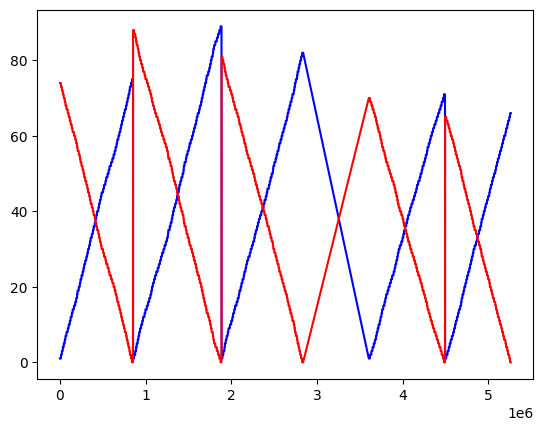

In [16]:
plt.plot(NASAdataset_df_train['cycle'], c='b')
plt.plot(NASAdataset_df_train['RUL'], c='r')

In [17]:
#consider single unit & single cycle & single unit in single flight
NASAdataset_df_train_u5 = NASAdataset_df_train[NASAdataset_df_train['unit'] == 5].copy()
NASAdataset_df_train_u5 = NASAdataset_df_train_u5.astype(float)

NASAdataset_df_test_u15 = NASAdataset_df_test[NASAdataset_df_test['unit'] == 15].copy()
NASAdataset_df_test_u15 = NASAdataset_df_test_u15.astype(float)

NASAdataset_df_train_c30 = NASAdataset_df_train[NASAdataset_df_train['cycle'] == 30].copy()
NASAdataset_df_train_c30 = NASAdataset_df_train_c30.astype(float)

NASAdataset_df_train_c70 = NASAdataset_df_train[NASAdataset_df_train['cycle'] == 70].copy()
NASAdataset_df_train_c70 = NASAdataset_df_train_c30.astype(float)

NASAdataset_df_train_u5_c30 = NASAdataset_df_train[(NASAdataset_df_train['unit']==5) & (NASAdataset_df_train['cycle']==30)].copy()
NASAdataset_df_train_u5_c30 = NASAdataset_df_train_u5_c30.astype(float)

NASAdataset_df_train_u5_c70 = NASAdataset_df_train[(NASAdataset_df_train['unit']==5) & (NASAdataset_df_train['cycle']==70)].copy()
NASAdataset_df_train_u5_c70 = NASAdataset_df_train_u5_c70.astype(float)

NASAdataset_df_train_u5_c89 = NASAdataset_df_train[(NASAdataset_df_train['unit']==5) & (NASAdataset_df_train['cycle']==89)].copy()
NASAdataset_df_train_u5_c89 = NASAdataset_df_train_u5_c89.astype(float)

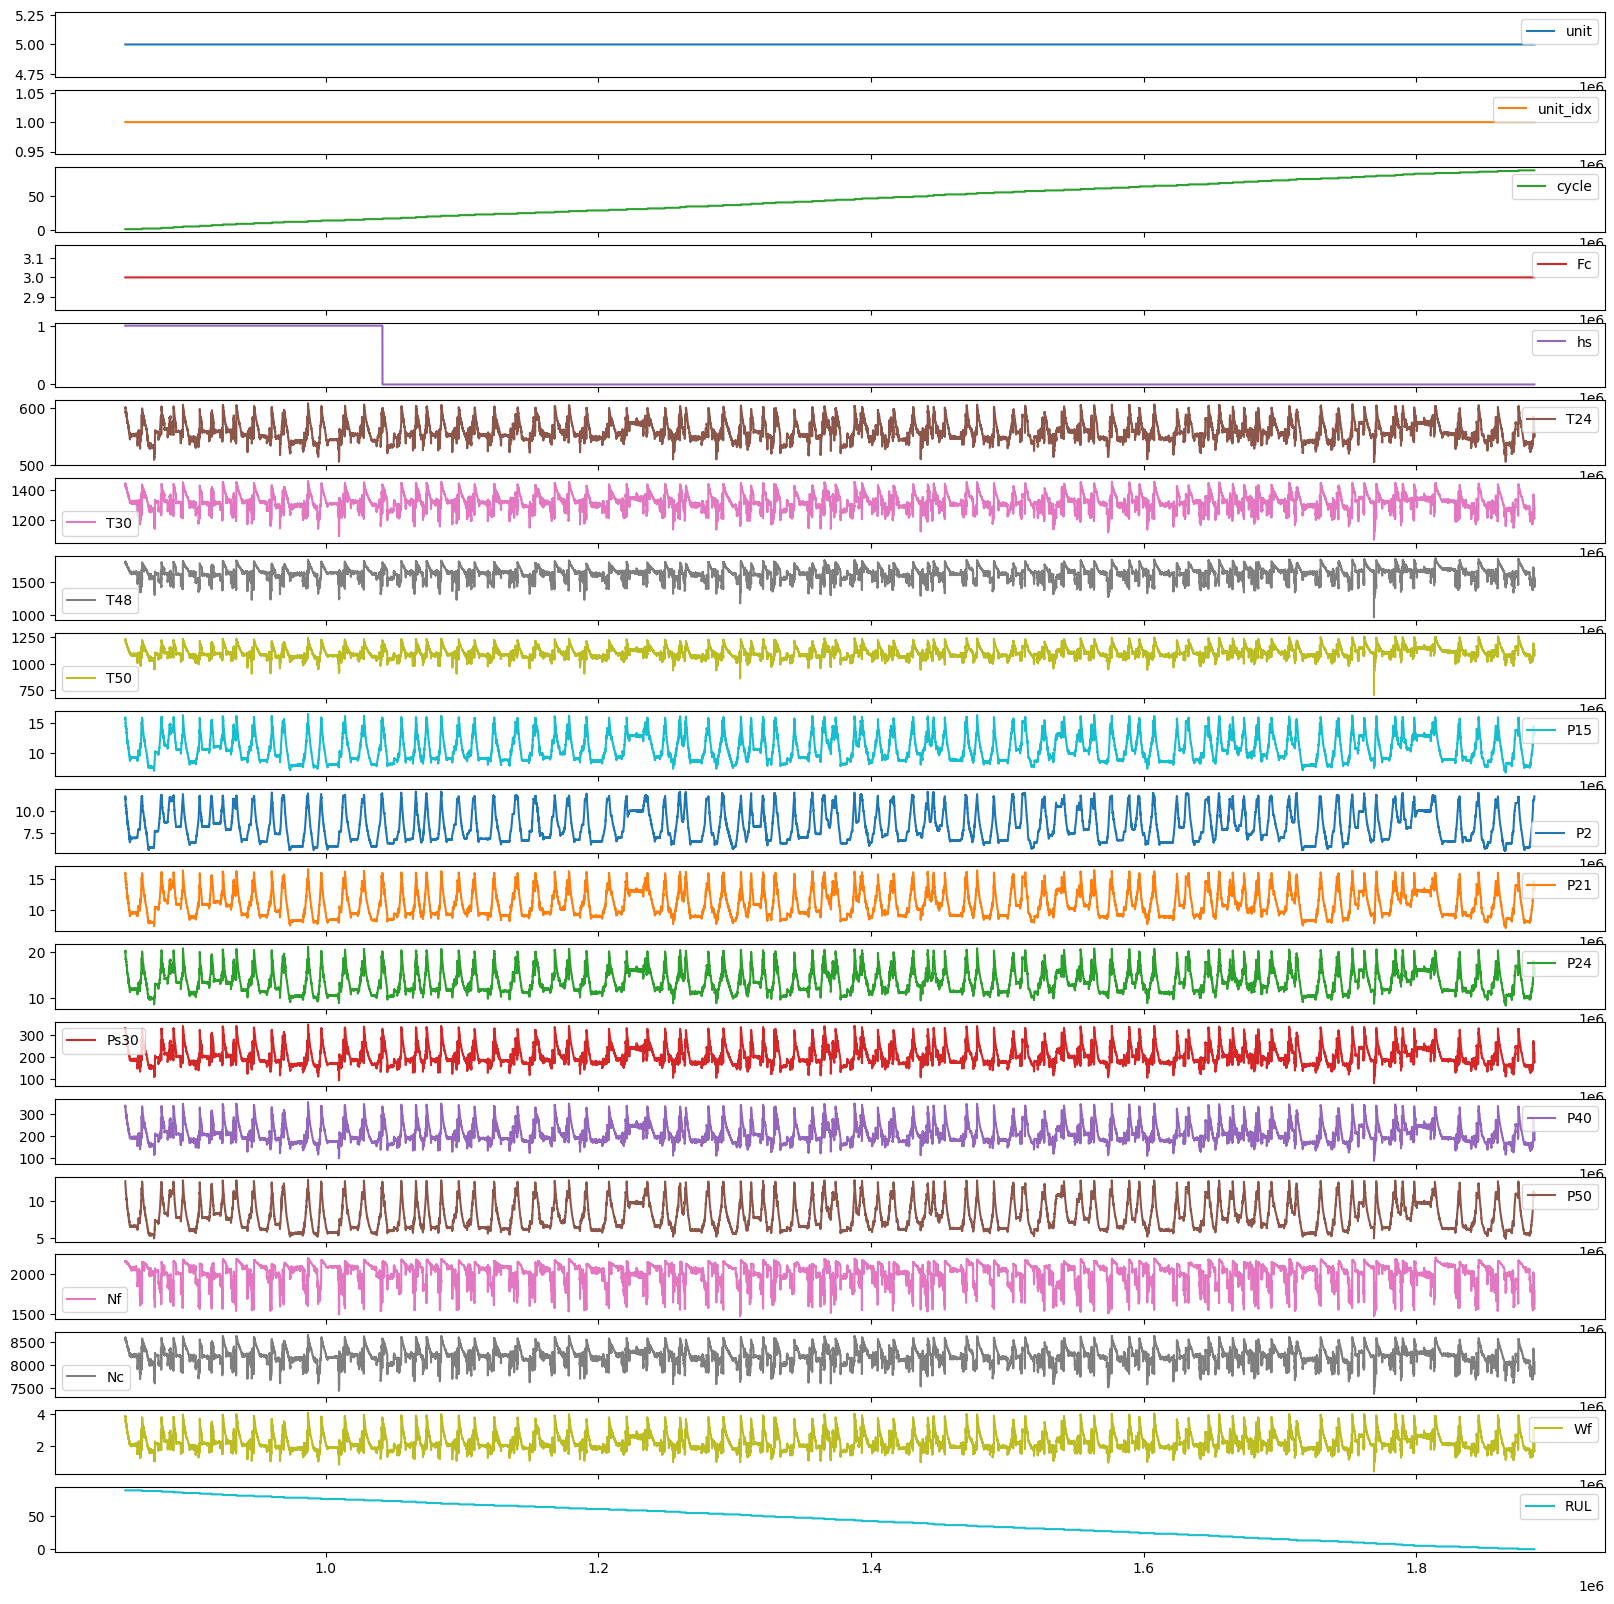

In [18]:
u5 = NASAdataset_df_train_u5.plot(subplots=True, figsize=(20,20))

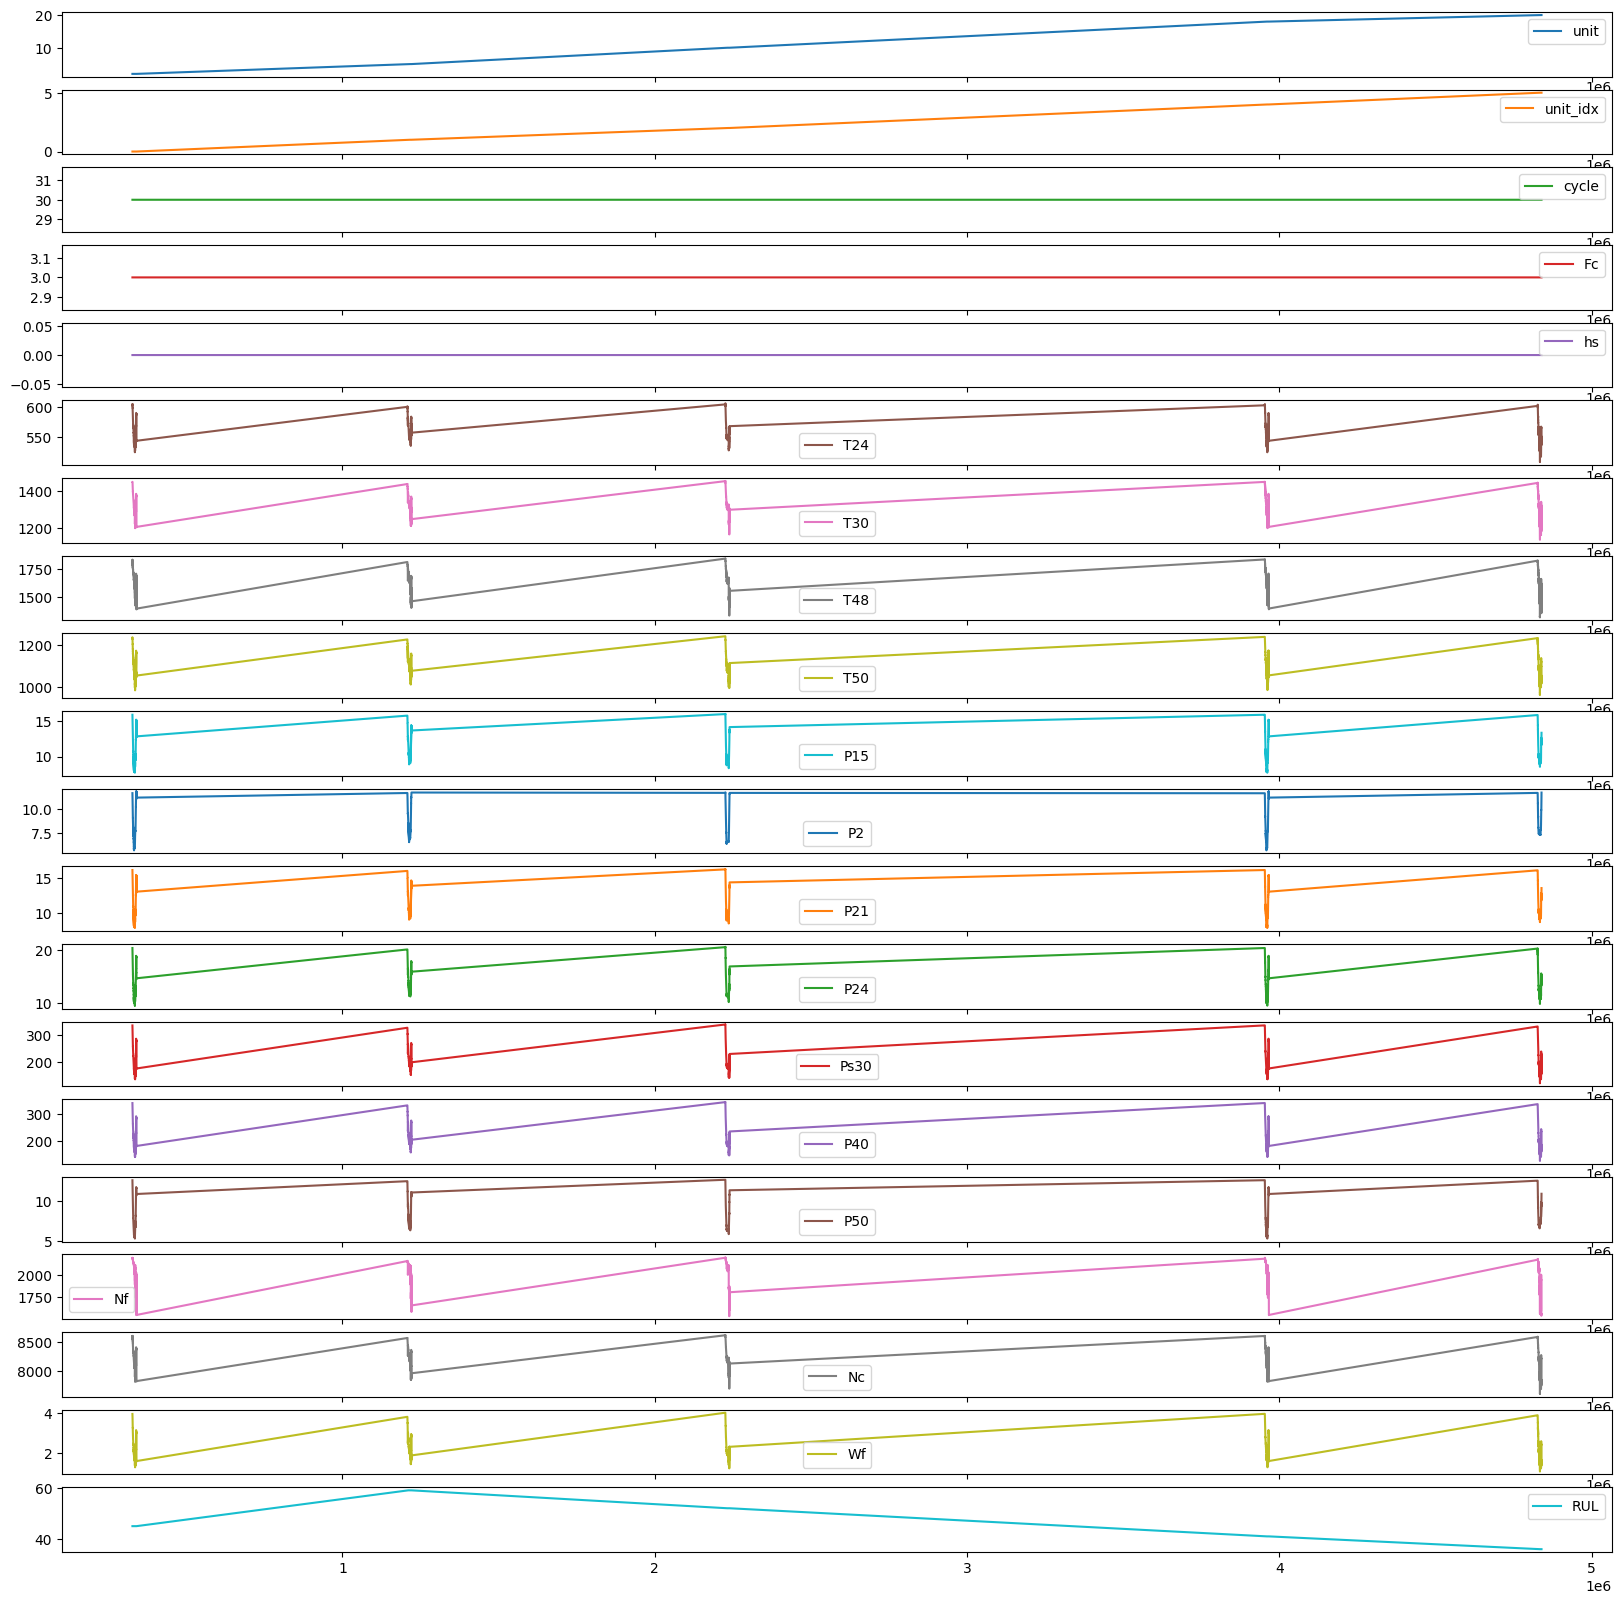

In [19]:
c30 = NASAdataset_df_train_c30.plot(subplots=True, figsize=(20,20))

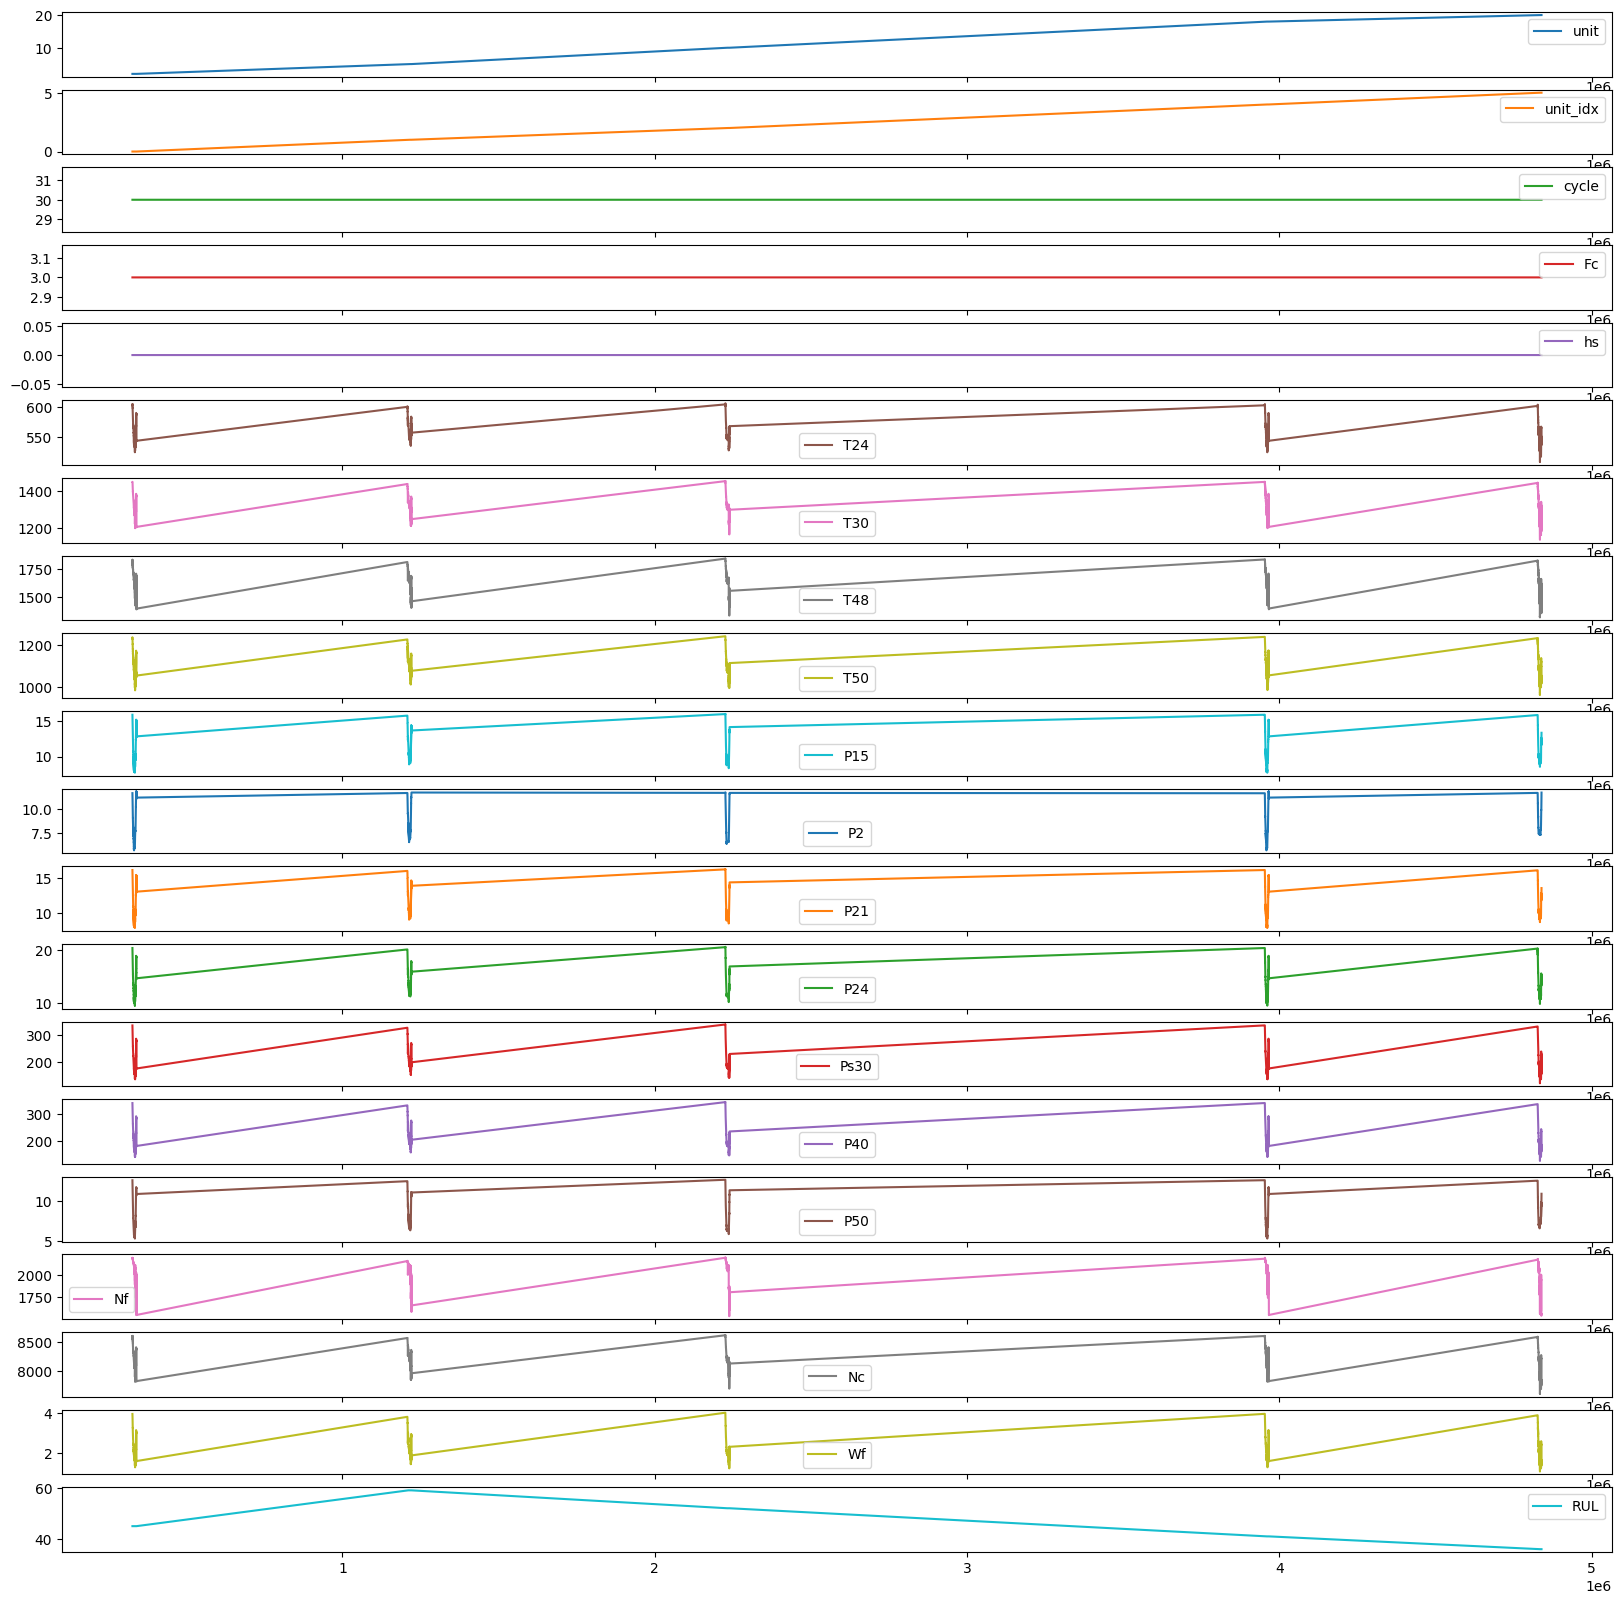

In [20]:
c70 = NASAdataset_df_train_c70.plot(subplots=True, figsize=(20,20))

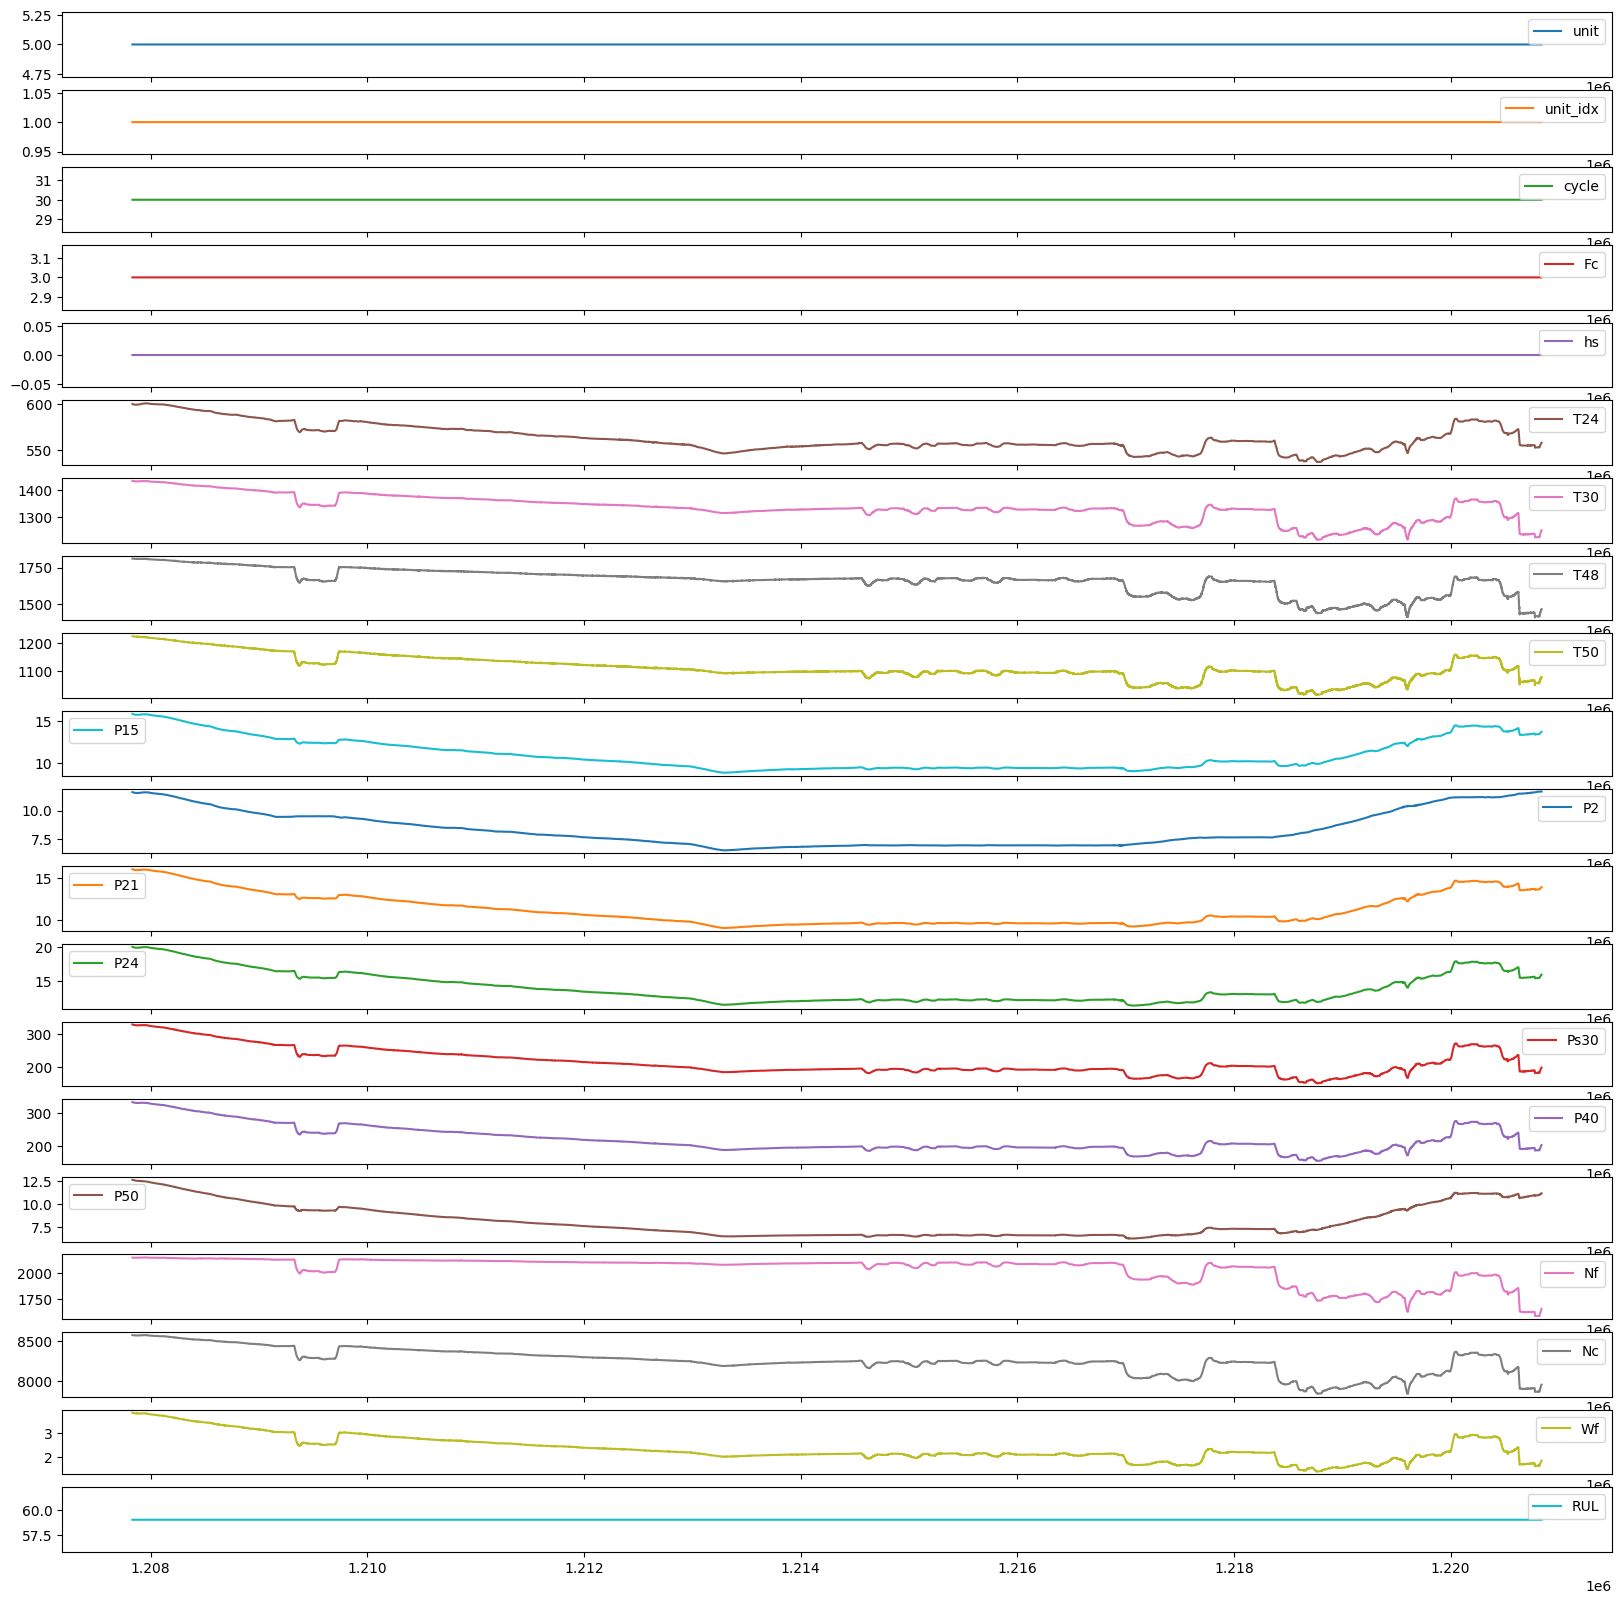

In [21]:
u5_c30 = NASAdataset_df_train_u5_c30.plot(subplots=True, figsize=(20,20))

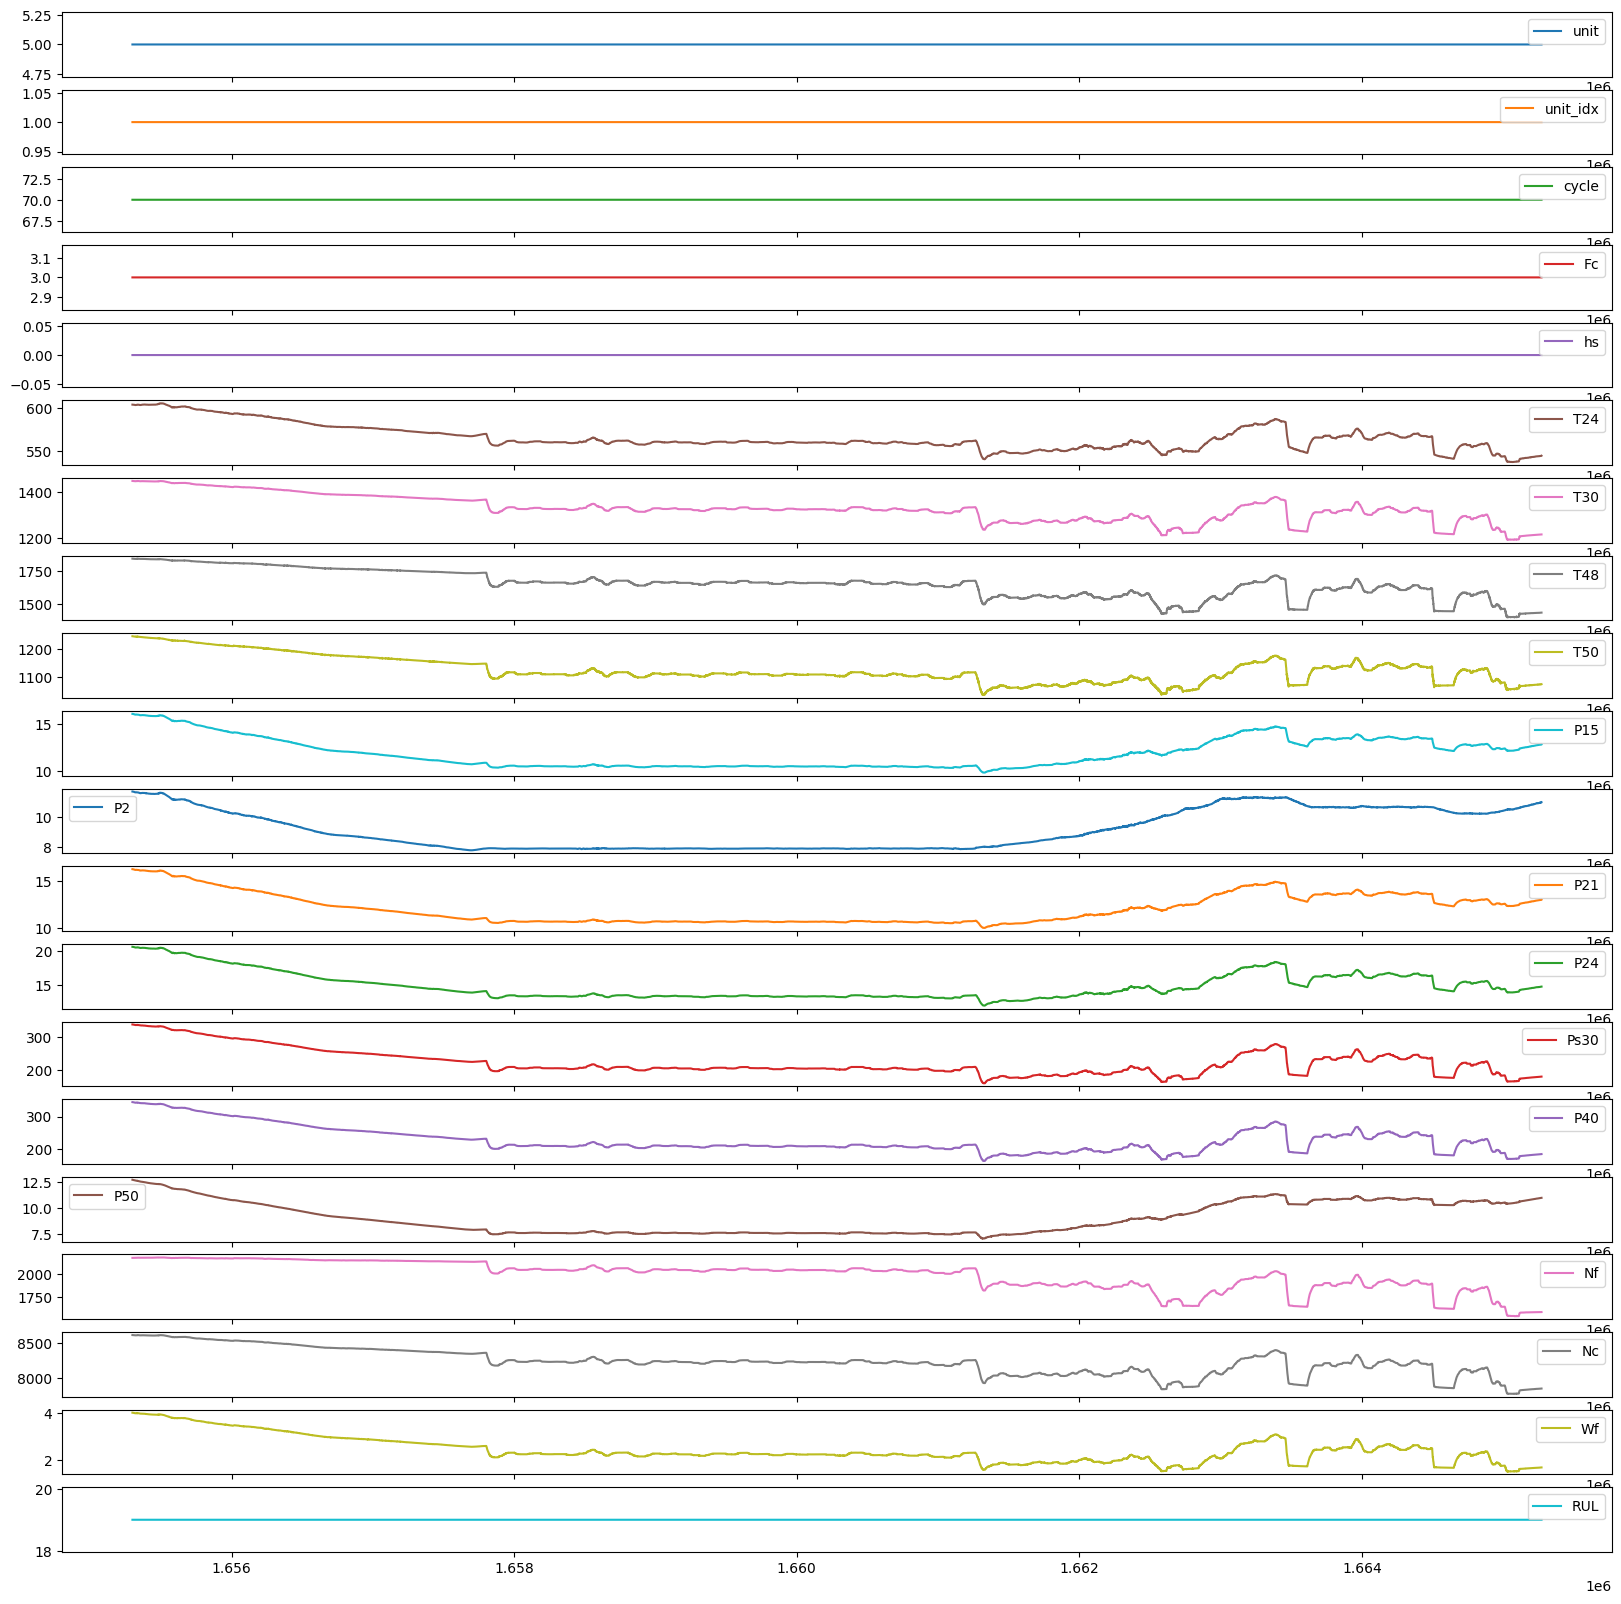

In [22]:
u5_c70 = NASAdataset_df_train_u5_c70.plot(subplots=True, figsize=(20,20))

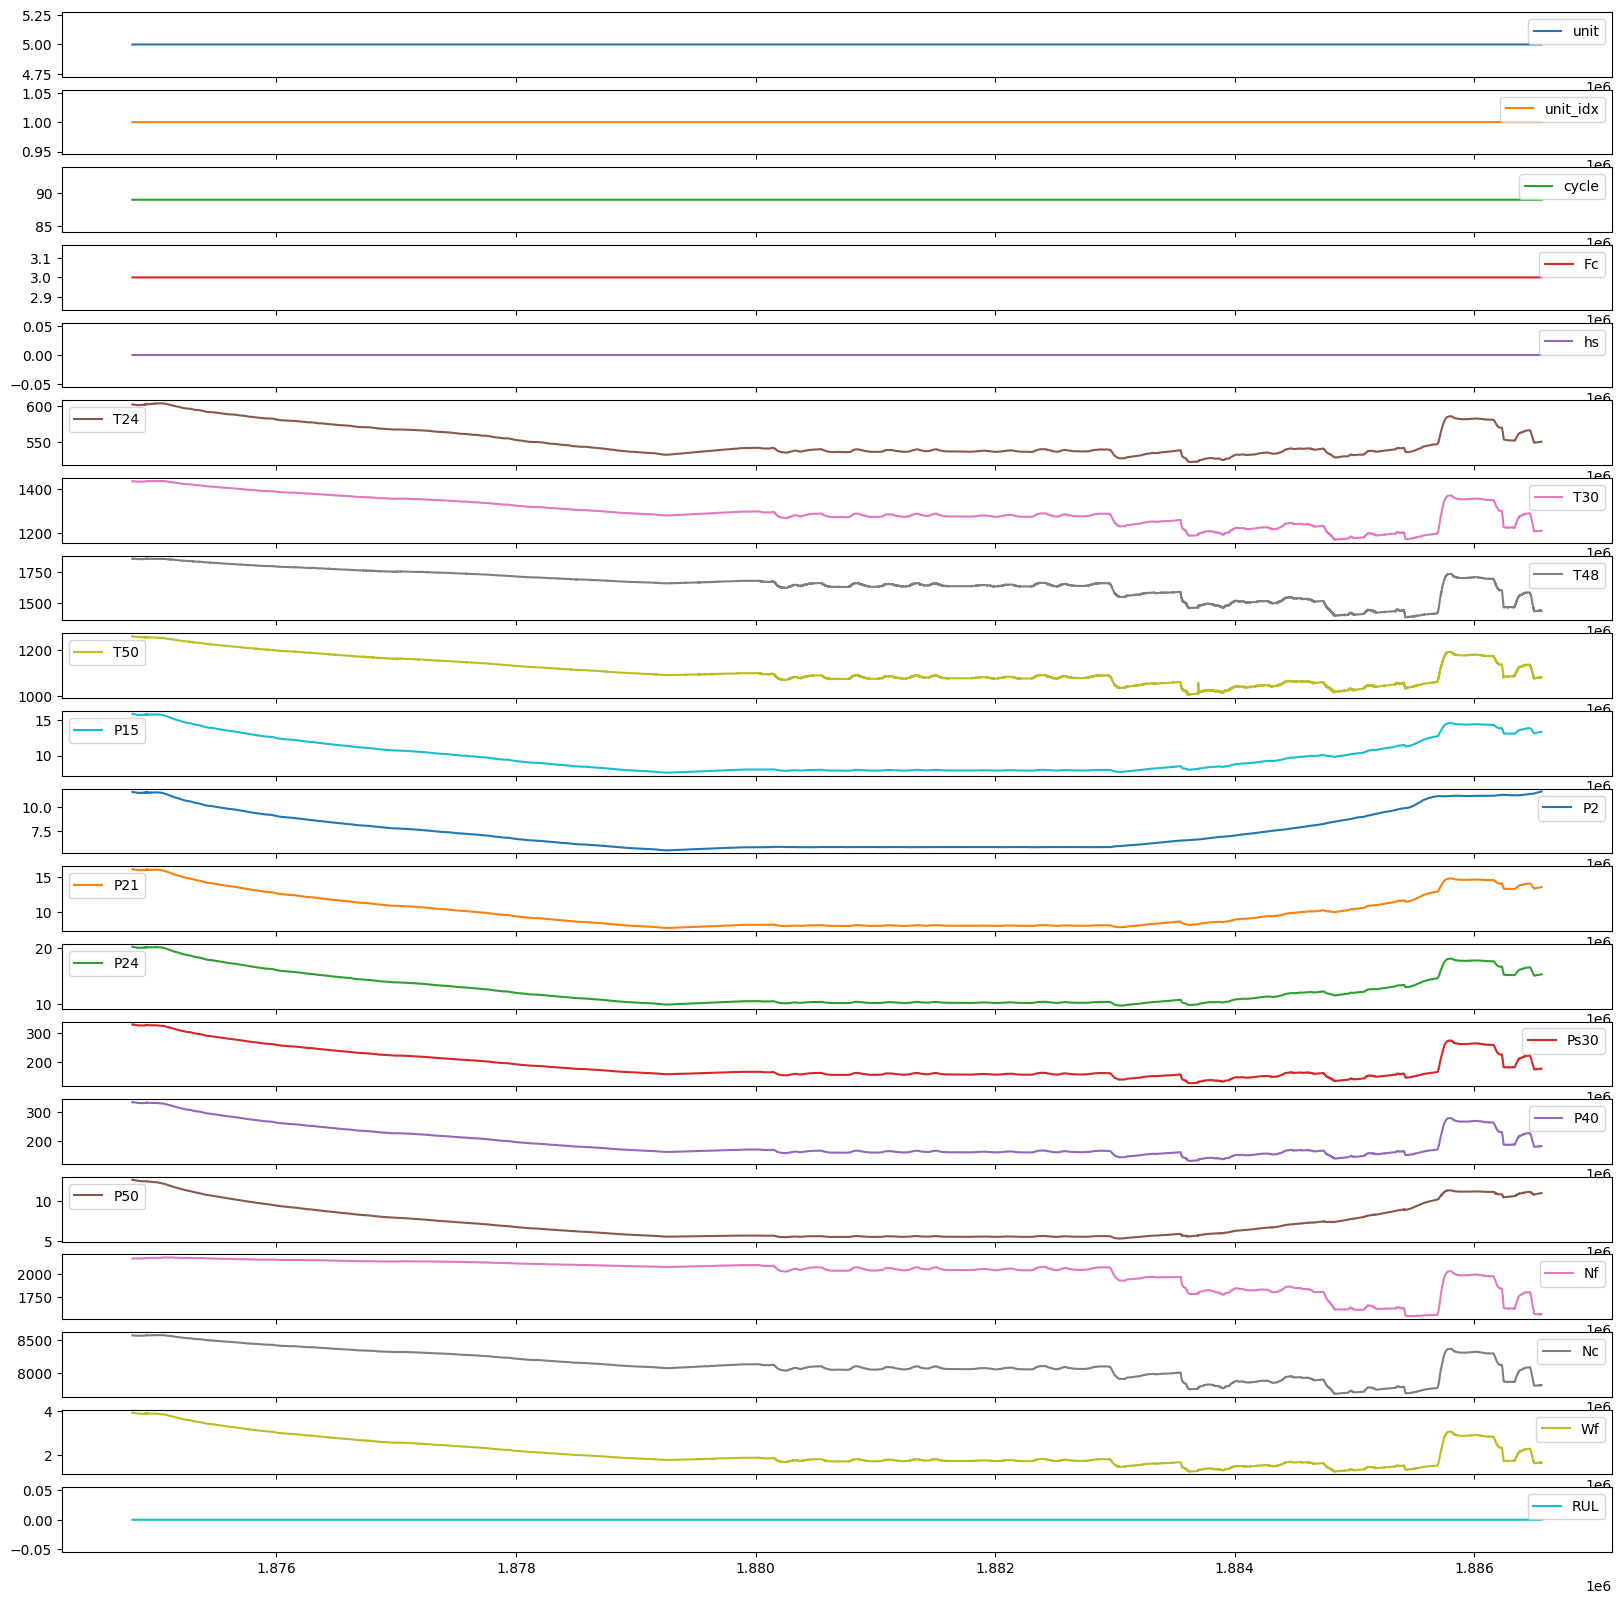

In [23]:
#fail
u5_c89 = NASAdataset_df_train_u5_c89.plot(subplots=True, figsize=(20,20))

In [24]:
# RUL analysis
maxrul_u = NASAdataset_df_train.groupby('unit').max().reset_index()
maxrul_u

,unit,unit_idx,cycle,Fc,hs,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,RUL
0,2.0,0.0,75.0,3.0,1.0,616.796557,1486.457251,1909.452866,1272.542428,16.918859,12.268619,17.176506,21.984966,371.823231,377.457779,13.193475,2263.476825,8740.188729,4.521983,74.0
1,5.0,1.0,89.0,3.0,1.0,608.792674,1458.611822,1870.644992,1261.478464,16.445422,12.165295,16.695860,21.104300,348.391997,353.937798,12.853226,2212.444056,8654.795910,4.110213,88.0
2,10.0,2.0,82.0,3.0,1.0,606.729148,1453.422438,1876.439179,1267.300756,16.284803,12.189874,16.532795,20.751570,342.672183,348.085341,12.797049,2205.483602,8638.457935,4.066605,81.0
3,18.0,4.0,71.0,3.0,1.0,616.714755,1487.274864,1912.816178,1276.669155,16.918259,12.268619,17.175898,21.978381,372.484460,378.155881,13.210040,2263.477056,8745.187108,4.539436,70.0
4,20.0,5.0,66.0,3.0,1.0,610.637816,1468.537464,1898.923768,1284.410062,16.374098,12.216071,16.623450,21.114727,354.267472,359.529337,12.993743,2222.218747,8678.287213,4.305223,65.0


In [25]:
#check if there are empty values
print(NASAdataset_df_train.isnull().sum())
print(NASAdataset_df_train.dtypes)

unit        0
unit_idx    0
cycle       0
Fc          0
hs          0
T24         0
T30         0
T48         0
T50         0
P15         0
P2          0
P21         0
P24         0
Ps30        0
P40         0
P50         0
Nf          0
Nc          0
Wf          0
RUL         0
dtype: int64
unit        float64
unit_idx    float64
cycle       float64
Fc          float64
hs          float64
T24         float64
T30         float64
T48         float64
T50         float64
P15         float64
P2          float64
P21         float64
P24         float64
Ps30        float64
P40         float64
P50         float64
Nf          float64
Nc          float64
Wf          float64
RUL         float64
dtype: object


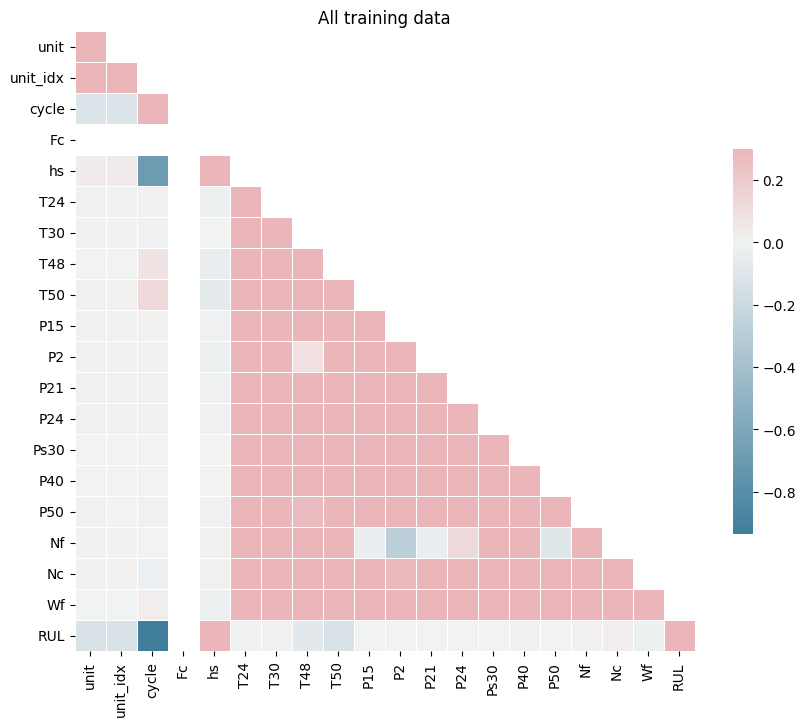

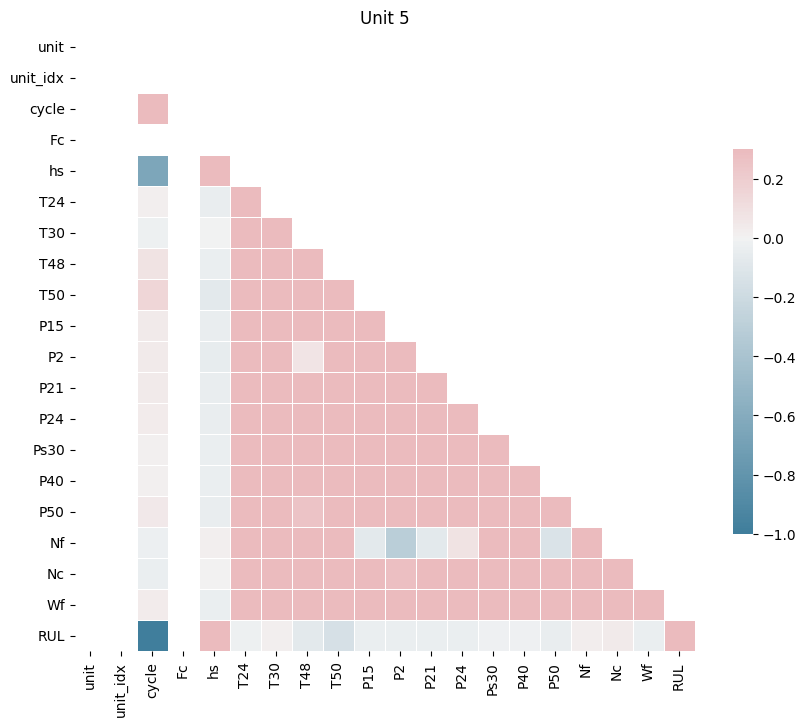

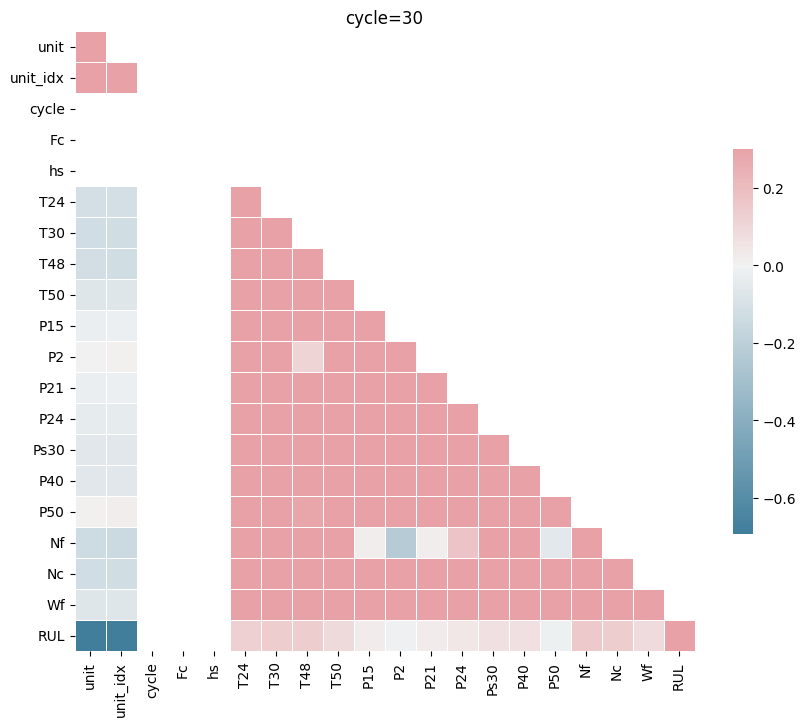

In [26]:
def heatmap_corr(dataframe, title):
    corr = dataframe.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    np.fill_diagonal(mask, False)
    f, ax = plt.subplots(figsize=(10, 10))
    cmap = sns.diverging_palette(230, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title(title)

heatmap_corr(NASAdataset_df_train, 'All training data')
heatmap_corr(NASAdataset_df_train_u5, 'Unit 5')
heatmap_corr(NASAdataset_df_train_c30, 'cycle=30')

In [27]:
Sensor_dictionary={}
dict_list=["T24",
    "T30",
    "T48",
    "T50",
    "P15",
    "P2",
    "P21",
    "P24",
    "Ps30",
    "P40",
    "P50",
    "Nf",
    "Nc",
    "Wf"]
    
for x in dict_list :
    Sensor_dictionary[x]=x
    
Sensor_dictionary

{'T24': 'T24',
 'T30': 'T30',
 'T48': 'T48',
 'T50': 'T50',
 'P15': 'P15',
 'P2': 'P2',
 'P21': 'P21',
 'P24': 'P24',
 'Ps30': 'Ps30',
 'P40': 'P40',
 'P50': 'P50',
 'Nf': 'Nf',
 'Nc': 'Nc',
 'Wf': 'Wf'}

In [28]:
# Plot the evolution of features(from sensors) along with the evolution with RUL

# def plot_signal(df, Sensor_dic, signal_name):
#     plt.figure(figsize=(13,5))
#     # for i in df['unit'].unique():
#     #     plt.plot('RUL', signal_name, data=df[df['unit']==i].rolling(10).mean())
#     plt.plot('RUL', signal_name, data=df[df['unit']==5].rolling(10).mean())


#     plt.xlim(100, 0)  # reverse the x-axis so RUL counts down to zero
#     plt.ylabel(Sensor_dic[signal_name])
#     plt.xlabel('Remaining Useful Life')
#     plt.show()

# for x in dict_list:
#     try:
#         plot_signal(NASAdataset_df_train, Sensor_dictionary, x)
#     except:
#         pass

In [29]:
y_train = NASAdataset_df_train_u5['RUL'].to_numpy()
y_test = NASAdataset_df_test_u15['RUL'].to_numpy()
y_train.shape, y_test.shape

((1033420,), (433470,))

# 1. Dimensionality Reduction(PCA)

In [30]:
# observe correlation between temperature measurement
print(NASAdataset_df_train_u5[['T24','T30','T48','T50']].corr())
#Get X-train_4 as inputs
X_train_T = NASAdataset_df_train_u5[['T24','T30','T48','T50']].to_numpy()
X_test_T = NASAdataset_df_test_u15[['T24','T30','T48','T50']].to_numpy()
print(X_train_T.shape)
print(X_test_T.shape)

          T24       T30       T48       T50
T24  1.000000  0.876248  0.730518  0.945524
T30  0.876248  1.000000  0.962554  0.942844
T48  0.730518  0.962554  1.000000  0.872059
T50  0.945524  0.942844  0.872059  1.000000
(1033420, 4)
(433470, 4)


In [31]:
#Get error of random forest training on just(X_train_T, y_train) and testing on (X_test_4, y_test)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

forest_base = RandomForestRegressor(n_estimators=50, max_depth=5).fit(X_train_T, y_train)
forest_base_test_predictions = forest_base.predict(X_test_T)
mean_absolute_error(y_test, forest_base_test_predictions)

16.497777040748478

In [32]:
# Train PCA (Linear Dimensionality Reduction) with 2/3-feature output

from sklearn.decomposition import PCA

pca = PCA(n_components=3) #3:MAE=14; 2:MAE=18; 1:MAE=18
pca = pca.fit(X_train_T)

pca

PCA(n_components=3)

In [33]:
# Use PCA to transform X_train_T and X_test_T into X_train_pca and X_test_pca

X_train_T_pca = pca.transform(X_train_T)
X_test_T_pca = pca.transform(X_test_T)

X_train_T_pca.shape, X_test_T_pca.shape

((1033420, 3), (433470, 3))

In [34]:
# Get error of Random Forest training on (X_train_pca, y_train) and testing on (X_test_pca, y_test)

forest_pca = RandomForestRegressor(n_estimators=50, max_depth=5).fit(X_train_T_pca, y_train)
forest_pca_test_predictions = forest_pca.predict(X_test_T_pca)

mean_absolute_error(y_test, forest_pca_test_predictions)

14.070109353117045

# 2. Preprocessing/Scaling

In [35]:
X_train_T

array([[ 600.84471026, 1440.36399975, 1821.34370503, 1229.66316503],
       [ 600.56622877, 1439.88633955, 1820.22912499, 1228.94101796],
       [ 600.54090556, 1439.87662156, 1820.83139483, 1229.48305857],
       ...,
       [ 550.57505659, 1211.94024726, 1433.91993073, 1080.40472398],
       [ 550.59731761, 1211.98680265, 1434.15151895, 1080.62429985],
       [ 550.63021526, 1212.06306568, 1434.21794849, 1080.66243959]])

(array([1.00000e+00, 0.00000e+00, 1.00000e+00, 1.49000e+02, 3.85500e+03,
        5.06230e+04, 4.28496e+05, 3.41091e+05, 1.59466e+05, 4.97380e+04]),
 array([-8.08807084, -6.97000334, -5.85193583, -4.73386833, -3.61580082,
        -2.49773331, -1.37966581, -0.2615983 ,  0.8564692 ,  1.97453671,
         3.09260421]),
 <BarContainer object of 10 artists>)

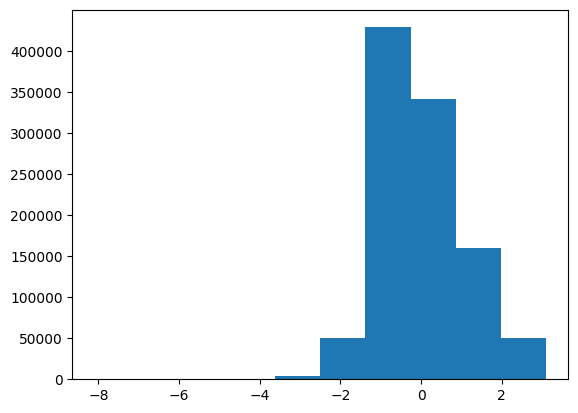

In [36]:
# Test different preprocessing functions on X_train_3

from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler

scaler = StandardScaler().fit(X_train_T)
X_train_T_scaled = scaler.transform(X_train_T)

plt.hist(X_train_T_scaled[:, 3])

In [37]:
X_train_T_scaled

array([[ 2.40757577,  2.26541409,  1.8699125 ,  2.46023903],
       [ 2.39131616,  2.25645089,  1.85823322,  2.44588554],
       [ 2.38983763,  2.25626853,  1.86454419,  2.45665921],
       ...,
       [-0.52750195, -2.02091437, -2.18976025, -0.50644192],
       [-0.5262022 , -2.02004077, -2.18733352, -0.5020776 ],
       [-0.52428142, -2.01860971, -2.18663743, -0.50131953]])

In [38]:
# Preprocess X_test_4

X_test_T_scaled = scaler.transform(X_test_T)

X_test_T_scaled.shape

(433470, 4)

In [39]:
# Get error of Random Forest training on (X_train_scaled, y_train) and testing on (X_test_scaled, y_test)

random_forest_scaled = RandomForestRegressor(n_estimators=50, max_depth=5).fit(X_train_T_scaled, y_train)
random_forest_scaled_test_predictions = random_forest_scaled.predict(X_test_T_scaled)

mean_absolute_error(y_test, random_forest_scaled_test_predictions)

16.59445263673196

In [40]:
# Create Pipeline of Normalization -> PCA -> RandomForest

from sklearn.pipeline import Pipeline

scale_pca_pipe_forest = Pipeline(steps=[('Scaler', Normalizer()), # tried 'Standardscaler' MAE:14.48
                                 ('PCA', PCA(n_components=3)), 
                                 ('Forest', RandomForestRegressor(n_estimators=50, max_depth=5))])
scale_pca_pipe_forest

Pipeline(steps=[('Scaler', Normalizer()), ('PCA', PCA(n_components=3)),
                ('Forest',
                 RandomForestRegressor(max_depth=5, n_estimators=50))])

In [41]:
# Get error of Normalization -> PCA -> Random Forest pipeline

scale_pca_pipe_forest.fit(X_train_T, y_train) # when we call fit, it calls step1, then pass into step2, then step3 in pipeline
scale_pca_pipe_forest_test_predictions = scale_pca_pipe_forest.predict(X_test_T)

mean_absolute_error(y_test, scale_pca_pipe_forest_test_predictions)

12.143248961361827

# Pressure features
# Normalizer -> PCA -> RandomForest: Pressure measurement

In [42]:
X_train_P = NASAdataset_df_train_u5[['P15','P2','P21','P24','Ps30','P40','P50']].to_numpy()
X_test_P = NASAdataset_df_test_u15[['P15','P2','P21','P24','Ps30','P40','P50']].to_numpy()
print(NASAdataset_df_train_u5[['P15','P2','P21','P24','Ps30','P40','P50']].corr())
print(X_train_P.shape, X_test_P.shape)

           P15        P2       P21       P24      Ps30       P40       P50
P15   1.000000  0.970552  1.000000  0.987968  0.859317  0.862579  0.994576
P2    0.970552  1.000000  0.970552  0.921781  0.710894  0.715398  0.977819
P21   1.000000  0.970552  1.000000  0.987968  0.859317  0.862579  0.994576
P24   0.987968  0.921781  0.987968  1.000000  0.927632  0.929996  0.973562
Ps30  0.859317  0.710894  0.859317  0.927632  1.000000  0.999978  0.828441
P40   0.862579  0.715398  0.862579  0.929996  0.999978  1.000000  0.831927
P50   0.994576  0.977819  0.994576  0.973562  0.828441  0.831927  1.000000
(1033420, 7) (433470, 7)


In [43]:
#Get error of random forest training on just(X_train_P, y_train) and testing on (X_test_P, y_test)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

forest_base = RandomForestRegressor(n_estimators=50, max_depth=5).fit(X_train_P, y_train)
forest_base_test_predictions = forest_base.predict(X_test_P)
mean_absolute_error(y_test, forest_base_test_predictions)

19.04112557011495

In [44]:
# Train PCA (Linear Dimensionality Reduction) with smaller-feature output
from sklearn.decomposition import PCA
pca_P = PCA(n_components=4) #3:18; 4:11
pca_P = pca_P.fit(X_train_P)

# Use PCA to transform X_train_P and X_test_P into X_train_pca and X_test_pca
X_train_P_pca = pca_P.transform(X_train_P)
X_test_P_pca = pca_P.transform(X_test_P)
print(X_train_P_pca.shape, X_test_P_pca.shape)

(1033420, 4) (433470, 4)


In [45]:
# Get error of Random Forest training on (X_train_P_pca, y_train) and testing on (X_test_P_pca, y_test)
forest_pca = RandomForestRegressor(n_estimators=50, max_depth=5).fit(X_train_P_pca, y_train)
forest_pca_test_predictions = forest_pca.predict(X_test_P_pca)
mean_absolute_error(y_test, forest_pca_test_predictions)

11.944676666535587

In [46]:
# Create Pipeline of Normalization -> PCA -> RandomForest

from sklearn.pipeline import Pipeline

scale_pca_pipe_forest = Pipeline(steps=[('Scaler', Normalizer()), # 'Normalizer':MAE=15; 'Standardscaler':MAE=18
                                 ('PCA', PCA(n_components=4)), 
                                 ('Forest', RandomForestRegressor(n_estimators=50, max_depth=5))])
scale_pca_pipe_forest

Pipeline(steps=[('Scaler', Normalizer()), ('PCA', PCA(n_components=4)),
                ('Forest',
                 RandomForestRegressor(max_depth=5, n_estimators=50))])

In [47]:
# Get error of Normalization -> PCA -> Random Forest pipeline
scale_pca_pipe_forest.fit(X_train_P, y_train) # when we call fit, it calls step1, then pass into step2, then step3 in pipeline
scale_pca_pipe_forest_test_predictions = scale_pca_pipe_forest.predict(X_test_P)
mean_absolute_error(y_test, scale_pca_pipe_forest_test_predictions)

15.386339396728735

# Binning(Grouping, Aggregating)

<AxesSubplot:>

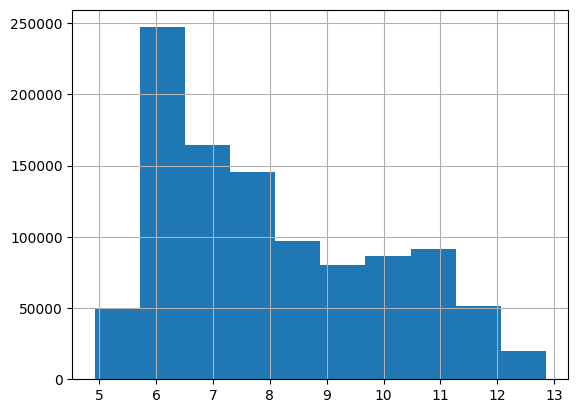

In [48]:
NASAdataset_df_train_u5['P50'].hist()

# New features as inputs

In [49]:
# normalize
T_scaler = Normalizer().fit(X_train_T_pca)
X_train_T_PCA_scaled = T_scaler.transform(X_train_T_pca)

P_scaler = Normalizer().fit(X_train_P_pca)
X_train_P_PCA_scaled = P_scaler.transform(X_train_P_pca)

X_train_Nf = NASAdataset_df_train_u5['Nf'].to_numpy()
X_train_Nf = X_train_Nf.reshape(-1,1)
Nf_scaler = StandardScaler().fit(X_train_Nf)
X_train_Nf_scaled = Nf_scaler.transform(X_train_Nf)

X_train_Nc = NASAdataset_df_train_u5['Nc'].to_numpy()
X_train_Nc = X_train_Nc.reshape(-1,1)
Nc_scaler = StandardScaler().fit(X_train_Nc)
X_train_Nc_scaled = Nc_scaler.transform(X_train_Nc)

X_train_Wf = NASAdataset_df_train_u5['Wf'].to_numpy()
X_train_Wf = X_train_Wf.reshape(-1,1)
Wf_scaler = StandardScaler().fit(X_train_Wf)
X_train_Wf_scaled = Wf_scaler.transform(X_train_Wf)

# convert to DataFrame
X_train_T_PCA_scaled_df = pd.DataFrame(X_train_T_PCA_scaled, columns=['T1', 'T2', 'T3'])
X_train_P_PCA_scaled_df = pd.DataFrame(X_train_P_PCA_scaled, columns=['P1','P2','P3','P4'])
X_train_Nf_scaled_df = pd.DataFrame(X_train_Nf_scaled, columns=['Nf'])
X_train_Nc_scaled_df = pd.DataFrame(X_train_Nc_scaled, columns=['Nc'])
X_train_Wf_scaled_df = pd.DataFrame(X_train_Wf_scaled, columns=['Wf'])
X_train_T_PCA_scaled_df = X_train_T_PCA_scaled_df.reset_index(drop=True)
X_train_P_PCA_scaled_df = X_train_P_PCA_scaled_df.reset_index(drop=True)
X_train_Nf_scaled_df = X_train_Nf_scaled_df.reset_index(drop=True)
X_train_Nc_scaled_df = X_train_Nc_scaled_df.reset_index(drop=True)
X_train_Wf_scaled_df = X_train_Wf_scaled_df.reset_index(drop=True)


# add processed features
NASAdataset_df_train_u5_new = NASAdataset_df_train_u5.copy()
fields_to_drop_T = ['T24','T30','T48','T50']
fields_to_drop_P = ['P15','P2','P21','P24','Ps30','P40','P50']
fields_to_drop_other = ['Nf','Nc','Wf']
NASAdataset_df_train_u5_new.drop(fields_to_drop_T, axis=1, inplace=True)
NASAdataset_df_train_u5_new.drop(fields_to_drop_P, axis=1, inplace=True)
NASAdataset_df_train_u5_new.drop(fields_to_drop_other, axis=1, inplace=True)

NASAdataset_df_train_u5_new.reset_index(drop=True, inplace=True)
NASAdataset_df_train_u5_new = pd.concat([NASAdataset_df_train_u5_new, X_train_T_PCA_scaled_df],axis=1)
NASAdataset_df_train_u5_new = pd.concat([NASAdataset_df_train_u5_new, X_train_P_PCA_scaled_df],axis=1)
NASAdataset_df_train_u5_new = pd.concat([NASAdataset_df_train_u5_new, X_train_Nf_scaled_df],axis=1)
NASAdataset_df_train_u5_new = pd.concat([NASAdataset_df_train_u5_new, X_train_Nc_scaled_df],axis=1)
NASAdataset_df_train_u5_new = pd.concat([NASAdataset_df_train_u5_new, X_train_Wf_scaled_df],axis=1)

def move_column(df, col_name, pos):
    """Move a column to a specific position in a dataframe."""
    # Get the column index
    col_index = df.columns.get_loc(col_name)
    # Remove the column from the dataframe
    col = df.pop(col_name)
    # Insert the column at the desired position
    df.insert(pos, col_name, col)
    return df

move_column(NASAdataset_df_train_u5_new, 'T1', 5)
move_column(NASAdataset_df_train_u5_new, 'T2', 6)
move_column(NASAdataset_df_train_u5_new, 'T3', 7)
move_column(NASAdataset_df_train_u5_new, 'P1', 8)
move_column(NASAdataset_df_train_u5_new, 'P2', 9)
move_column(NASAdataset_df_train_u5_new, 'P3', 10)
move_column(NASAdataset_df_train_u5_new, 'P4', 11)
move_column(NASAdataset_df_train_u5_new, 'Nf', 12)
move_column(NASAdataset_df_train_u5_new, 'Nc', 13)
move_column(NASAdataset_df_train_u5_new, 'Wf', 14)


NASAdataset_df_train_u5_new

,unit,unit_idx,cycle,Fc,hs,T1,T2,T3,P1,P2,P3,P4,Nf,Nc,Wf,RUL
0,5.0,1.0,1.0,3.0,1.0,-0.989778,0.142393,0.007962,0.999993,-0.003167,-0.001793,0.000382,1.116705,2.218053,2.930906,88.0
1,5.0,1.0,1.0,3.0,1.0,-0.989735,0.142652,0.008680,0.999993,-0.003244,-0.001864,0.000413,1.115788,2.210770,2.916158,88.0
2,5.0,1.0,1.0,3.0,1.0,-0.989769,0.142510,0.006953,0.999993,-0.003247,-0.001887,0.000392,1.112595,2.209296,2.919580,88.0
3,5.0,1.0,1.0,3.0,1.0,-0.989759,0.142545,0.007620,0.999993,-0.003268,-0.001891,0.000404,1.113248,2.207944,2.914524,88.0
4,5.0,1.0,1.0,3.0,1.0,-0.989761,0.142556,0.007192,0.999993,-0.003302,-0.001927,0.000407,1.111535,2.203992,2.909279,88.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033415,5.0,1.0,89.0,3.0,0.0,0.953597,0.279045,-0.113076,-0.981003,0.193751,-0.008453,-0.004828,-3.302797,-2.187125,-1.106746,0.0
1033416,5.0,1.0,89.0,3.0,0.0,0.951345,0.283314,-0.121145,-0.980800,0.194753,-0.008834,-0.005039,-3.312448,-2.186619,-1.092954,0.0
1033417,5.0,1.0,89.0,3.0,0.0,0.951992,0.282307,-0.118382,-0.980697,0.195277,-0.008741,-0.004977,-3.308996,-2.183410,-1.095195,0.0
1033418,5.0,1.0,89.0,3.0,0.0,0.951754,0.282837,-0.119025,-0.980621,0.195655,-0.008776,-0.005002,-3.309447,-2.182854,-1.093581,0.0


# Loading data

In [50]:
import tqdm
import gpytorch
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution, DeltaVariationalDistribution, MeanFieldVariationalDistribution
from gpytorch.distributions import MultivariateNormal
from gpytorch.models import ApproximateGP, GP
from gpytorch.mlls import VariationalELBO, AddedLossTerm
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.mlls import DeepApproximateMLL

In [51]:
import tensorflow as tf
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("logs/20220306")
import torchvision
import sys

/Users/yuhanlin/miniforge3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/yuhanlin/miniforge3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  Referenced from: <73E740D8-1ED7-3AF3-9ECC-9BD50541DCCE> /Users/yuhanlin/miniforge3/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <81BECF83-B792-341D-B3A5-E56611AD1DB7> /Users/yuhanlin/miniforge3/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [60]:
# Building training dataloader
Train_x_df = NASAdataset_df_train_u5_new.iloc[:, 5:15]
Train_x_np = Train_x_df.values
Train_x = torch.tensor(Train_x_np, dtype=torch.float32)

Train_y_df = NASAdataset_df_train_u5_new.iloc[:, -1]
Train_y_np = Train_y_df.values
Train_y = torch.tensor(Train_y_np, dtype=torch.float32)

from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(Train_x, Train_y)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

# Building test dataloader
Test_x_df = NASAdataset_df_test_u15.iloc[:, 5:15]
Test_x_np = Test_x_df.values
Test_x = torch.tensor(Test_x_np, dtype=torch.float32)

Test_y_df = NASAdataset_df_test_u15.iloc[:, -1]
Test_y_np = Test_y_df.values
Test_y = torch.tensor(Test_y_np, dtype=torch.float32)

test_dataset = TensorDataset(Test_x, Test_y)
test_loader = DataLoader(test_dataset, batch_size=1024)

In [53]:
# Define DGP and GP layer
class ToyDeepGPHiddenLayer(DeepGPLayer):    #returns samples of q(f)
    def __init__(self, input_dims, output_dims, num_inducing=128, mean_type='constant'):
        # output layer
        if output_dims is None:
            inducing_points = torch.randn(num_inducing, input_dims)#random initialization from N(0,1)
            batch_shape = torch.Size([])#default
        # hidden layer
        else: 
            inducing_points = torch.randn(output_dims, num_inducing, input_dims) #output_dims(2): check FIGURE 1 in ETH paper, first hidden layer has 2 GPs
            mean_type = 'linear',
            batch_shape = torch.Size([output_dims])

        variational_distribution = CholeskyVariationalDistribution(    #q(u):marginal variational distribution
            num_inducing_points = num_inducing,
            batch_shape = batch_shape #define the shape of batch,Z.B. torch.Size([4,3])
        )

        variational_strategy = VariationalStrategy(    #q(f)=integral(p(f|u)q(u))du, defines how to compute q(f)
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True #Whether or not the inducing point locations 𝐙 should be learned (i.e. are they parameters of the model).
        )

        super(ToyDeepGPHiddenLayer, self).__init__(variational_strategy, input_dims, output_dims)    #inherit _init_() from father “DeepGPLayer”

        self.variational_distribution = variational_distribution

        if mean_type == 'constant':
            self.mean_module = ConstantMean(batch_shape=batch_shape)
        else:
            self.mean_module = LinearMean(input_dims)
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=batch_shape, ard_num_dims=input_dims),
            batch_shape=batch_shape, ard_num_dims=None
        )

    def forward(self, x):    #returns posterior
        # print("shape of x:", x.shape)
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        # print("shape of mean:", mean_x.shape)
        # print("shape of covar:", covar_x.shape)
        return MultivariateNormal(mean_x, covar_x) #Constructs a multivariate normal random variable, based on mean and covariance

    def __call__(self, x, *other_inputs, **kwargs):
        """
        Overriding __call__ isn't strictly necessary, but it lets us add concatenation based skip connections
        easily. For example, hidden_layer2(hidden_layer1_outputs, inputs) will pass the concatenation of the first
        hidden layer's outputs and the input data to hidden_layer2.
        """
        if len(other_inputs):
            if isinstance(x, gpytorch.distributions.MultitaskMultivariateNormal):
                x = x.rsample()

            processed_inputs = [
                inp.unsqueeze(0).expand(gpytorch.settings.num_likelihood_samples.value(), *inp.shape)
                for inp in other_inputs
            ]

            x = torch.cat([x] + processed_inputs, dim=-1)

        return super().__call__(x, are_samples=bool(len(other_inputs)))

In [61]:
num_hidden_dims = 3 #the number of outputs of the first (hidden layer)，which means the first layer has 2 GPs

# in this example we build a 2-layers DGP
class DeepGP(DeepGP):#this class should contain "DeepGPLayer" modules, which we defined already above
    def __init__(self, train_x_shape):
        hidden_layer = ToyDeepGPHiddenLayer(
            input_dims = train_x_shape[-1], #1, number of features
            output_dims = num_hidden_dims, #check FIGURE 1 in ETH paper, first hidden layer has 2 GPs
            mean_type = 'linear',
        )

        last_layer = ToyDeepGPHiddenLayer(
            input_dims = hidden_layer.output_dims,
            output_dims = None,
            mean_type = 'constant',
        )

        super().__init__()

        self.hidden_layer = hidden_layer
        self.last_layer = last_layer
        self.likelihood = GaussianLikelihood()
        self.inducing_value = self.hidden_layer.variational_distribution() #新加的

    def forward(self, inputs):    #responsible for forwarding through the various layers
        hidden_rep1 = self.hidden_layer(inputs)
        output = self.last_layer(hidden_rep1)
        return output

    def get_inducing(self): #新加的
        return self.inducing_value

    def predict(self, test_loader): #returns the mean, variance, and log marginal likelihood of the predictions
        with torch.no_grad():
            mus = []
            variances = []
            lls = [] #log likelihood score
            for x_batch, y_batch in test_loader:
                preds = self.likelihood(self(x_batch)) #mapping from latent function value f(X) to observed labels y
                # prediction.append(preds)
                mus.append(preds.mean) #length of mus is 102
                # print("preds.mean.shape:", preds.mean.shape)
                variances.append(preds.variance)
                # print("preds.variance.shape:", preds.variance.shape)
                lls.append(model.likelihood.log_marginal(y_batch, model(x_batch)))

        return torch.cat(mus, dim=-1), torch.cat(variances, dim=-1), torch.cat(lls, dim=-1), preds # in tutorial didn't return preds


In [55]:
model = DeepGP(Train_x.shape)
if torch.cuda.is_available():
    model = model.cuda()
model.state_dict()

OrderedDict([('hidden_layer.variational_strategy.inducing_points',
              tensor([[[-1.3042,  1.0017,  2.5683,  ..., -0.8078, -0.1550, -0.4815],
                       [-1.3788, -0.9907, -1.1685,  ..., -0.4683,  1.1676,  1.9198],
                       [-0.1483,  0.2184,  1.1993,  ..., -0.2096,  0.9828,  0.2900],
                       ...,
                       [ 1.0752, -0.8169, -0.3919,  ..., -1.1963,  0.6018, -1.1041],
                       [-1.1393,  0.5169,  0.1047,  ..., -0.2994, -1.4706, -1.1014],
                       [ 0.4726,  0.2561, -0.0489,  ..., -1.7931, -0.2663,  0.5042]],
              
                      [[-1.1297,  0.9608, -0.9533,  ...,  2.3888, -0.8591, -1.9968],
                       [ 0.0515, -1.1027,  0.4539,  ...,  0.3192, -0.5231, -1.2877],
                       [ 0.3775, -1.3413, -0.5839,  ..., -0.5860, -0.1923,  0.3775],
                       ...,
                       [-1.0200,  0.7885, -1.7729,  ...,  0.8341, -0.3740, -0.4312],
           

In [65]:
# this is for running the notebook in our testing framework(Training)
num_epochs = 1
num_samples = 10


optimizer = torch.optim.Adam([
    {'params': model.parameters()},
], lr=0.01)

# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

mll = DeepApproximateMLL(VariationalELBO(model.likelihood, model, Train_x.shape[0]))

epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
    for x_batch, y_batch in minibatch_iter:
        with gpytorch.settings.num_likelihood_samples(num_samples): # only defines the number of samples in hiddden GP, output sample number still will be default:10                                               
            optimizer.zero_grad()
            output = model(x_batch)
            loss = -mll(output, y_batch)
            writer.add_scalar('loss', loss, i)
            loss.backward()
            optimizer.step()

            minibatch_iter.set_postfix(loss=loss.item())

writer.close()
model.state_dict() # get the full state of a GPyTorch model
# torch.save(model.state_dict(), 'model_state.pth')
# state_dict = torch.load('model_state.pth') # load this state in to a new model
# model.load_state_dict(state_dict)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1010 [00:00<?, ?it/s]

/Users/yuhanlin/miniforge3/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


OrderedDict([('hidden_layer.variational_strategy.inducing_points',
              tensor([[[-0.3550,  0.1912,  0.2076,  ..., -0.5052,  1.4423,  1.1501],
                       [-1.4626, -0.8205,  0.9711,  ...,  2.6158,  4.1803,  2.1879],
                       [-0.6401,  0.1552,  0.0055,  ...,  1.0129,  1.1329,  0.6776],
                       ...,
                       [ 3.4117, -1.9433, -0.0556,  ..., -1.3054,  0.2224, -0.2340],
                       [ 1.0134, -0.0598, -0.1582,  ..., -2.6350, -3.2974, -1.4468],
                       [-1.0582,  2.7152, -2.5546,  ..., -2.6629,  1.5733,  1.8633]],
              
                      [[-1.1557,  1.1423, -1.7805,  ...,  2.4864, -1.1761, -1.9579],
                       [ 1.7960, -0.4583, -0.0582,  ..., -0.7403, -1.5126, -1.6255],
                       [ 0.9649,  0.3832, -0.1208,  ..., -1.8681, -1.3160, -0.5141],
                       ...,
                       [ 0.9127, -0.3364, -0.8913,  ..., -1.8830, -2.1863, -0.7710],
           

In [66]:
model.eval()
predictive_means, predictive_variances, test_lls, observed_pred = model.predict(test_loader)

rmse = torch.mean(torch.pow(predictive_means.mean(0) - Test_y, 2)).sqrt()
print(f"RMSE: {rmse.item()}, NLL: {-test_lls.mean().item()}")

RMSE: 35.28063201904297, NLL: 43.21212387084961
